### Template Matching

In [1]:
#============================================================================
# import packages
import cv2
import numpy as np
import imutils
import matplotlib.pylab as plt
%matplotlib inline

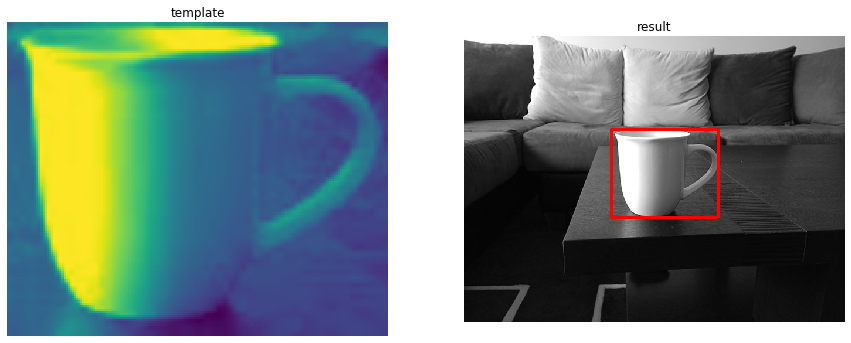

In [3]:
#============================================================================
# load data
src = cv2.imread('./data/input image.jpg', cv2.IMREAD_GRAYSCALE)
tmp = cv2.imread('./data/template.jpg', cv2.IMREAD_GRAYSCALE)
dst  = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)  # 출력 표시 영상

# TODO: 구현

#원본 데이터는 유지해야하기 때문에 도화지를 하나 더 준비한다.
dst2  = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

maxWidth = maxHeight = 0 #tmp 이미지 크기 변동을 위해 임시용 너비와 높이 변수를 선언해준다.
size = 0 #최대 넓이 사격형을 추출하기 위해 임시용 넓이 변수를 선언해준다.
maxPoint = 0 #사격형을 추출했을 때, 순서를 위한 임시 변수

#명확한 엣지를 추출하기 위해서 가오시안으로 블러셔를 해주고 canny에 적당한 threshod-Min,Max를 구해준다.
blurred = cv2.GaussianBlur(dst2,(3,3), 0.0)
canny = cv2.Canny(blurred, 80 , 250)

#그리고 엣지를 기준으로 레이블링을 해준다. ret은 레이블의 총갯수를 의미한다.
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(canny)

# 이때 stats는 배열형태로 좌표 x,y 너비와 높이 그리고 면적값을 가지고 있어서 최고의 넓이를 가진 stats 위치를 찾는다.
for i in range(1, int(ret)):
    x, y, width, height, area = stats[i]
    
    if(area > size):
        size = area
        maxPoint = i

#threshold로 색변환을 위해 dst2의 이미지의 색을 하나 줄여준다.
dst2 = dst2 - 1

#maxPoint값에 해당하는 사격형 부분의 색깔을 모두 흰색으로 바꿔준다.
dst2[stats[maxPoint][1] : stats[maxPoint][1] + stats[maxPoint][3],stats[maxPoint][0] : stats[maxPoint][0]+stats[maxPoint][2] ] = 255
#사각형 탐색이 컵과 손잡이를 따로 인식하기 때문에 손잡이 부분을 직접 찾아주니 maxPoint + 2에 해당했다.
maxPoint = maxPoint + 2
#그리고 손잡이 부분에 해당하는 사격형 부분의 색깔을 모두 흰색으로 바꿔준다.
dst2[stats[maxPoint][1] : stats[maxPoint][1] + stats[maxPoint][3],stats[maxPoint][0] : stats[maxPoint][0]+stats[maxPoint][2] ] = 255

#위에서 dst2의 색을 하나 줄여줬기 때문에 색이 254 보다 큰 값은 모두 255로 색변경 해준다.
_, dst2 = cv2.threshold(dst2, 254, 255, cv2.THRESH_BINARY)

#잡음이 남아 있기 때문에 모폴로지로 잡음을 제거해준다. 침식을 통해 잡음을 제거해주고 평창을 통해 원래대로 돌아간다.
kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(3,3))
dst2 = cv2.erode(dst2,kernel, iterations = 1)
dst2 = cv2.dilate(dst2, kernel, iterations = 1)

#dst2를 다시 흑백영상으로 바꿔주고 가장 외각의 윤관석능 찾고 다각형 근사 좌표를 변환한다. 
test = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
cnts, _ = cv2.findContours(test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#가장 큰 넓이인 사격형을 찾기 위해 size를 0으로 다시 초기화 해준다.
size = 0

for c in cnts:
    #boudingRect 함수를 통해 countour를 넣고 사격형을 찾아낸다.
    (x, y, w, h) = cv2.boundingRect(c)
    #최고의 넓이를 찾는다.
    if(w*h > size):
        size = w * h
        maxWidth = w
        maxHeight = h
    cv2.rectangle(dst2, (x, y), (x + w, y + h), (0,255,0), 2)

#최고의 넓이 만큼 보다 살짝 너비가 크게 tmp 사이즈를 변경해준다.
tmp = cv2.resize(tmp, dsize=(maxWidth+5, maxHeight))

#템플랫 메칭을 통해 원본영상과 tmp를 통해 가장 밝기 깞이 가장 일치하는 부분을 찾는다. SQDIFF라서 밝기 값이 가장 낮은 부분을 찾게된다.
r1 = cv2.matchTemplate(src, tmp, cv2.TM_SQDIFF_NORMED)
minVal , _ , minLoc, _ = cv2.minMaxLoc(r1)
w, h = tmp.shape[:2]

#이렇게 찾은 부분에 화면의 너비와 높이를 더해주면 된다.
cv2.rectangle(dst, minLoc, (minLoc[0]+h, minLoc[1]+w), (255,0,0), 3)
#============================================================================
# display
rows = 1
cols = 2
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(tmp)
ax1.set_title('template')
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(dst)
ax2.set_title('result')
ax2.axis("off")

plt.show()